<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 3. 最佳化(Optimizations)

目前，模型正在遇到[棋盤偽影問題(Checkerboard Problem)](https://distill.pub/2016/deconv-checkerboard/). 
<br/>
<center><img src="images/shoe_maybe.png" /></center>
<br/>
幸運的是，我們有一些技巧可以解決這個問題，並且整體改善模型的效能。
<br/>
<br/>

#### 學習目標

本課程練習(Lab)的目標是：

* 實作群組正規化(Group Normalization)

* 實作高斯誤差線性單元活化函數(GELU)

* 實作重排池化(Rearrange Pooling)

* 實作正弦位置內嵌(Sinusoidal Position Embeddings)

* 定義反向擴散函數(Reverse Diffusion Function)來模擬 `p`

* 再次嘗試生成服飾圖像

如同之前，讓我們使用 fashionMIST 來進行實驗：


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

# Visualization tools
import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz
from IPython.display import Image

# User defined libraries
from utils import other_utils
from utils import ddpm_utils

IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


我們已經創建了一個 [ddpm_util.py](utils/ddpm_utils.py) 文件，其中包含一個 `DDPM` 類別，用於集中放置我們的擴散模型（Diffusion Models）函式。讓我們使用它來設定與之前相同的 Beta 排程。

In [2]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

## 3.1 群組正規化（Group Normalization）和 高斯誤差線性單元活化函數(GELU)

The first improvement we will look at is optimizing our standard convolution process. We will be reusing this block many times throughout our neural network, so it is an important piece to get right.

我們將要探討的第一個改進是優化我們的標準卷積（Standard Convolution）過程。由於這個區塊將在整個神經網路中被多次重複使用，因此正確的實作這段是一個非常重要的部分。

### 3.1.1 群組正規化（Group Normalization）

批次正規化（[Batch Normalization](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338)） 將每個核心通道（Kernel channel）的輸出轉換為  [z-score](https://www.nlm.nih.gov/oet/ed/stats/02-910.html)。它通過計算批次輸入的平均值和標準偏差來實現這一點。如果批次大小很小，這種方法就不太有效。

另一方面，群組正規化（[Group Normalization](https://arxiv.org/pdf/1803.08494.pdf)） 對每個樣本圖像的核心群組(group of kernels)進行正規化，有效地「分組 (grouping)」了一組特徵。

<center><img src="images/groupnorm.png" /></center>
考慮到彩色圖像具有多個顏色通道（color channel），這可能會對生成圖像的輸出顏色產生有趣的影響。嘗試實驗看看其效果！

在 Aakash Bindal 的這篇 部落格文章 中了解更多關於正規化技術的資訊。

### 3.1.2 高斯誤差線性單元活化函數(GELU)

[ReLU](https://www.kaggle.com/code/dansbecker/rectified-linear-units-relu-in-deep-learning) 是一個常見的活化函數（Activation Function）選擇，因為它計算快速且容易計算梯度。不幸的是，它並不完美。當偏差項(bias term )是大量負值時，ReLU 神經元會「死亡」（["dies"](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks)），因為其輸出和梯度均為零。

在稍微犧牲一些計算能力的情況下，[GELU](https://arxiv.org/pdf/1606.08415.pdf) 嘗試通過模仿 ReLU 函式的形狀，但同時去避免梯度為零的情況來糾正(rectify) ReLU。

在這個使用 FashionMNIST 的小範例中，很不可能會看到「死亡」神經元的情況。然而，模型越大，就越有可能面臨「死亡 ReLU」現象。

In [3]:
class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## 3.2 重新排列池化（Rearrange Pooling）


在之前的Noebook，我們使用了最大池化（[Max Pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)）來將隱（latent）圖像的大小減半，但這是最好的技術嗎？有[許多種類的池化層]((https://pytorch.org/docs/stable/nn.html#pooling-layers))，包括最小池化（Min Pooling）和平均池化（Average Pooling）。那麼，讓神經網路決定什麼是重要的吧。

這時，[einops](https://einops.rocks/1-einops-basics/)庫和重新排列（[Rearrange](https://einops.rocks/api/rearrange/)）層就派上用場了。我們可以為每層指派一個變數，並使用它來重新排列我們的值。此外，我們可以使用括號`()`來標示一組需要相乘的變數。

例如，在下面的程式碼區塊中，我們有：

`Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)`

* `b`是我們的批次維度（batch dimension）
* `c`是我們的通道維度（channel dimension）
* `h`是我們的高度維度（height dimension）
* `w`是我們的寬度維度（width dimension）

我們還有`p1`和`p2`的值，它們都等於`2`。等式左邊的部分在箭頭之前表示「將高度和寬度維度分成兩半」。等式右邊的部分在箭頭之後表示「沿著通道維度(channel dimension)堆疊分割的維度(stack split dimensions)」。

下面的程式碼區塊設定了一個`test_image`來練習。嘗試在箭頭左邊交換`h`和`p1`，會發生什麼？如果交換`w`和`p2`，會發生什麼？如果`p1`設為`3`而不是`2`，會發生什麼？

In [4]:
from einops.layers.torch import Rearrange

rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)

test_image = [
    [
        [
            [1, 2, 3, 4, 5, 6],
            [7, 8, 9, 10, 11, 12],
            [13, 14, 15, 16, 17, 18],
            [19, 20, 21, 22, 23, 24],
            [25, 26, 27, 28, 29, 30],
            [31, 32, 33, 34, 35, 36],
        ]
    ]
]
test_image = torch.tensor(test_image)
print(test_image)
output = rearrange(test_image)
output

tensor([[[[ 1,  2,  3,  4,  5,  6],
          [ 7,  8,  9, 10, 11, 12],
          [13, 14, 15, 16, 17, 18],
          [19, 20, 21, 22, 23, 24],
          [25, 26, 27, 28, 29, 30],
          [31, 32, 33, 34, 35, 36]]]])


tensor([[[[ 1,  3,  5],
          [13, 15, 17],
          [25, 27, 29]],

         [[ 2,  4,  6],
          [14, 16, 18],
          [26, 28, 30]],

         [[ 7,  9, 11],
          [19, 21, 23],
          [31, 33, 35]],

         [[ 8, 10, 12],
          [20, 22, 24],
          [32, 34, 36]]]])


接下來，我們可以將這個輸入傳遞給我們的 `GELUConvBlock`，讓神經網路決定如何在我們的「池」中權衡這些值。請注意 `GELUConvBlock` 的參數 `4*in_chs`？這是因為通道維度現在變得更大了，達到 p1 * p2 倍。


In [5]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

現在，我們已經具備了重新定義我們的 `DownBlocks` 和 `UpBlocks` 的組件。已經添加了多個 `GELUConvBlock` 來幫助解決 棋盤偽影問題(Checkerboard Problem)。


In [6]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

**待完成(TODO)**：有個變數輸入到 `UpBlock` 中導致`UpBlock`與 `DownBlock` 有所區別。這個輸入是什麼呢？

如果需要，請點擊下方的 `...` 以查看正確答案。


In [7]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, FIXME):
        x = FIXME
        x = FIXME
        return x

In [8]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

## 3.3 時間嵌入(Time Embeddings)


模型越能理解它在反向擴散過程中的時間步長(Timestep)，就越能正確地識別添加的噪訊(Noise)。在前面的筆記本中，我們為 `t/T` 創建了一個嵌入(embedding)。我們能否幫助模型更好地解釋這個嵌入？

在擴散模型(Diffusion Models)出現之前，這個問題一直困擾著自然語言處理。對於長對話，如何捕捉我們所在的位置？目標是找到一種方法，用少量連續數字來唯一地表示大量離散數字。使用單一浮點數無效，因為神經網路會將時間步長視為連續的，而不是離散的。[研究人員]((https://arxiv.org/pdf/1706.03762.pdf))最終選擇使用正弦和餘弦的總和。

關於為什麼這個方法有效以及如何開發這種技術的優秀解釋，請參考 Jonathan Kernes 的 [Master Positional Encoding](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3)。



In [9]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


**待完成(TODO)**：我們將把 `SinusoidalPositionEmbedBlock` 的輸出餵入我們的 `EmbedBlock`。幸運的是，我們的 `EmbedBlock` 仍然與之前相同。

看起來下面的程式碼已經被 `FIXMEs` 淹沒了。你還記得它原本應該是什麼樣子嗎？

如果需要，請點擊下方的 `...` 以查看正確答案。

In [10]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, FIXME),
            nn.GELU(),
            nn.Linear(emb_dim, FIXME),
            nn.Unflatten(1, (FIXME, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [11]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

## 3.4 殘差連接（Residual Connections）

最後一個消除棋盤偽影問題（Checkerboard Problem）的技巧是添加更多殘差或跳躍連接（skip connections）。我們可以為初始卷積創建一個 `ResidualConvBlock`。我們也可以在其他地方添加殘差連接，例如在我們的「`DownBlocks`」和「`UpBlocks`」中。

In [12]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out


以下是更新後的模型。請注意最後一行發生了什麼變化？從我們的 `ResidualConvBlock` 輸出到最終的 `self.out` 區塊中添加了另一個跳躍連接。這個連接出乎意料地強大，在上述所有變化中對這個資料集的棋盤偽影問題產生了最大的影響。

**待完成事項（TODO）**：新增了兩個變數：`small_group_size` 和 `big_group_size`，用於群組正規化（group normalization）。它們都依賴於變數 `group_base_size`。將 `group_base_size` 設為 `3`、`4`、`5`、`6` 或 `7` 之一。其中一個值是正確的，其他值將導致錯誤。

**提示（Hint）**：群組大小(group sizes)和 `down_chs` 相關。

如果需要，點擊下方的 `...` 以查看正確答案。


In [13]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 8
        group_size_base = FIXME
        small_group_size = 2 * group_size_base  # New
        big_group_size = 8 * group_size_base  # New
        

        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1)) # New

In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 8
        group_size_base = 4
        small_group_size = 2 * group_size_base # New
        big_group_size = 8 * group_size_base  # New
        

        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1)) # New

In [15]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  1979777



最後，是時候訓練模型了。讓我們看看這些修改所帶來的影響。



Epoch 0 | step 000 Loss: 1.096476435661316 


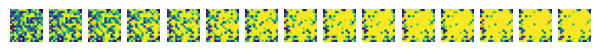

Epoch 0 | step 100 Loss: 0.16317778825759888 


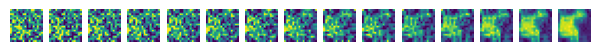

Epoch 0 | step 200 Loss: 0.14008983969688416 


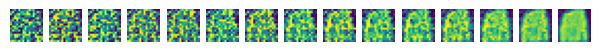

Epoch 0 | step 300 Loss: 0.1365148425102234 


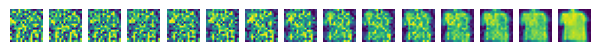

Epoch 0 | step 400 Loss: 0.12163856625556946 


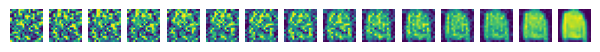

Epoch 0 | step 500 Loss: 0.11233961582183838 


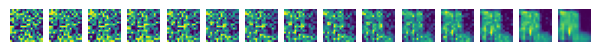

Epoch 1 | step 000 Loss: 0.11051163822412491 


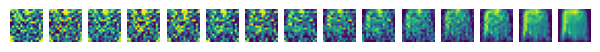

Epoch 1 | step 100 Loss: 0.08517111837863922 


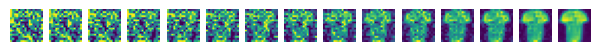

Epoch 1 | step 200 Loss: 0.11373768746852875 


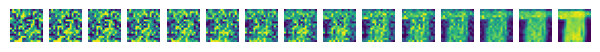

Epoch 1 | step 300 Loss: 0.10475920140743256 


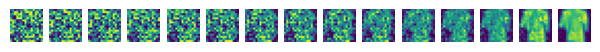

Epoch 1 | step 400 Loss: 0.11103355139493942 


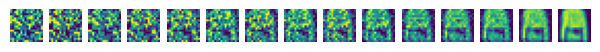

Epoch 1 | step 500 Loss: 0.09413478523492813 


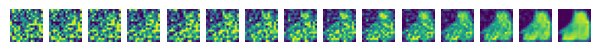

Epoch 2 | step 000 Loss: 0.12726178765296936 


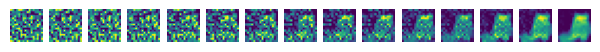

Epoch 2 | step 100 Loss: 0.08685671538114548 


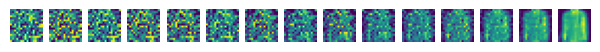

Epoch 2 | step 200 Loss: 0.0913090705871582 


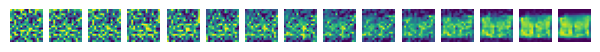

Epoch 2 | step 300 Loss: 0.11010127514600754 


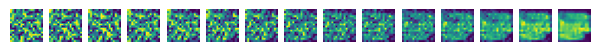

Epoch 2 | step 400 Loss: 0.0897575318813324 


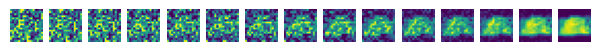

Epoch 2 | step 500 Loss: 0.08994187414646149 


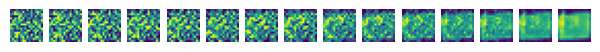

Epoch 3 | step 000 Loss: 0.1120365634560585 


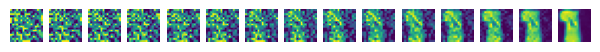

Epoch 3 | step 100 Loss: 0.10826903581619263 


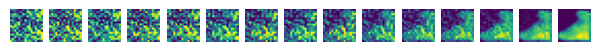

Epoch 3 | step 200 Loss: 0.0864666998386383 


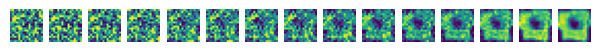

Epoch 3 | step 300 Loss: 0.09067614376544952 


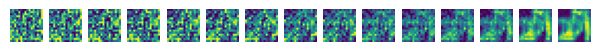

Epoch 3 | step 400 Loss: 0.10451166331768036 


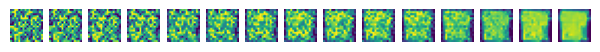

Epoch 3 | step 500 Loss: 0.09370394796133041 


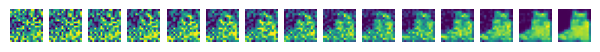

Epoch 4 | step 000 Loss: 0.09776318073272705 


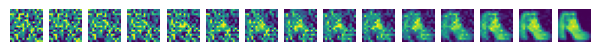

Epoch 4 | step 100 Loss: 0.10176411271095276 


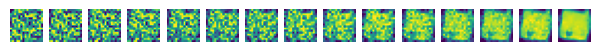

Epoch 4 | step 200 Loss: 0.09284955263137817 


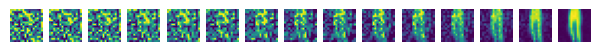

Epoch 4 | step 300 Loss: 0.0960686057806015 


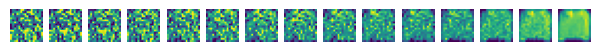

Epoch 4 | step 400 Loss: 0.0985727608203888 


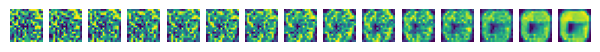

Epoch 4 | step 500 Loss: 0.09953692555427551 


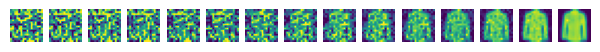

In [16]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        loss = ddpm.get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)


再來仔細看看吧。你能夠辨識出鞋子、手袋或襯衫嗎？



<Figure size 800x800 with 0 Axes>

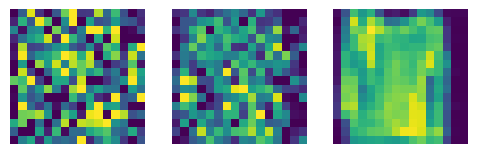

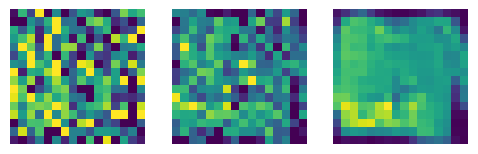

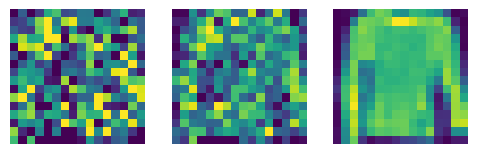

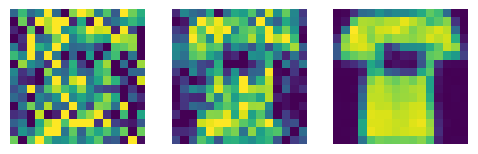

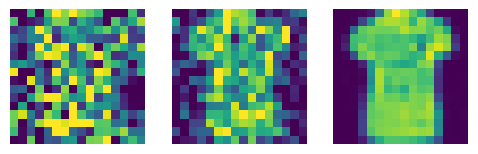

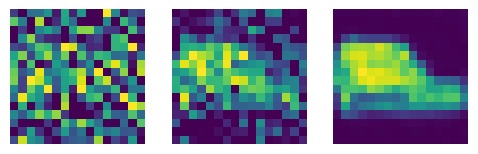

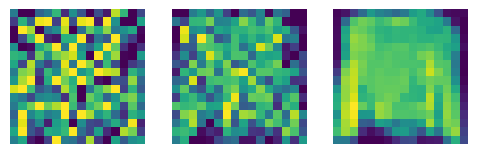

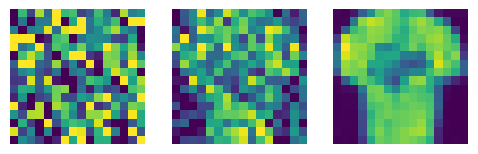

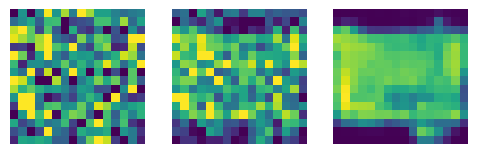

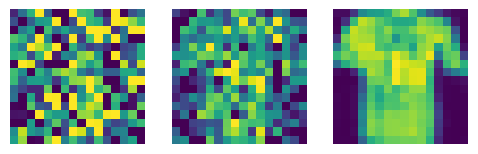

In [17]:
model.eval()
plt.figure(figsize=(8,8))
ncols = 3 # Should evenly divide T
for _ in range(10):
    ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)

## 3.5 下一步



如果你沒有看到某些類別，例如鞋子或襯衫，請嘗試再次運行上述程式碼區塊。目前，我們的模型不接受類別輸入，因此用戶無法定義他們想要的輸出類型。但這樣的話就沒有樂趣了。

在下一個筆記本中，我們將最終添加讓用戶控制模型的功能！


In [18]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>